# This notebook determines 'coastal' gridcells of the ERA 5 10 m u and v wind 21-yr avg dataset

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm

In [3]:
# load wind CSV:
avg_u_winds = pd.read_csv('avg_u_winds.csv')
avg_v_winds = pd.read_csv('avg_v_winds.csv')

lats_wind = pd.read_csv('wind_lats.csv')
lons_wind = pd.read_csv('wind_lons.csv')

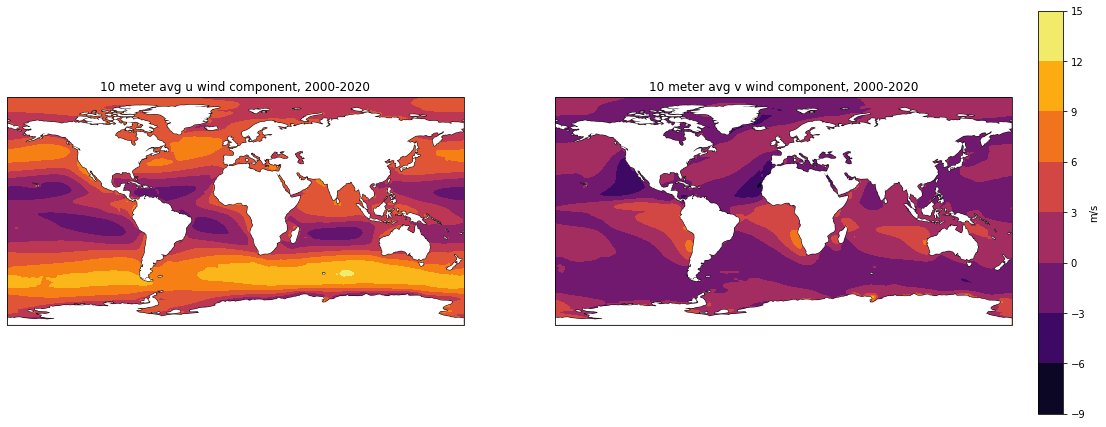

In [4]:
# Create the figure and the axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons_wind, lats_wind, avg_u_winds, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons_wind, lats_wind, avg_v_winds, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('10 meter avg v wind component, 2000-2020')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

### We want to classify every gridcell as 'coastal,' 'land,' or 'ocean'. We can achieve this with the following steps:
#### 1. Define a lat/lon grid that matches the dimensions of the ERA 5 wind grid: only classify between -60 and 70 lat for all lon
#### 2. Define a classification array to initialize all grids as 'ocean'
#### 3. Extract land polygons from the global 'land feature' from cartopy and assign them indices:
https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.feature.NaturalEarthFeature.html
#### 4. Define a function to determine if a given point is land
#### 5. Iterate through each grid cell and classify as 'land' or leave 'ocean', corresponding to 25% or more points within that grid cell being land
#### 6. Iterate through the new dataframe and make a 1 cell deep layer of 'coastal' cells around the land masses by reassigning 'ocean' cells.
#### 7. Save as a CSV

In [5]:
# 1. Define a lat/lon grid that matches the dimensions of the ERA 5 wind grid

# define the length of lat and lon
lat_length = 90
lon_length = 180

# generate arrays from -90 to 90 for lat and -180 to 180 for lon of the correct lengths
lats = np.linspace(-90, 90, lat_length)
lons = np.linspace(-180, 180, lon_length)

# reduce lat extent by cutting indices beyond -70 or 70 lat.
lats = lats[10:-10]
lat_length = len(lats)

# generate a meshgrid of those lats and lons
lon_grid, lat_grid = np.meshgrid(lons, lats)

# flatten the grids for more efficient iteration
flat_lons = lon_grid.flatten()
flat_lats = lat_grid.flatten()

In [6]:
# 2. Initialize the classification array as initially all 'coastal.'
classification = np.full_like(flat_lons, 'ocean', dtype='<U7') # string datatype corresponding to less than 7 characters

# 3. Use cartopy feature's physical, land, 110m Earth Feature
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m') # use moderately precise resolution of land data-- 1:50,000,000

# extract land polygons from the land feature
land_polygons = [geom for geom in land_feature.geometries()]

In [7]:
# 4. Define function to determine if a given point is land
def is_land(lat, lon, polygon_list):
    point = Point(lon, lat)
    
    # in all polygons
    for polygon in polygon_list:
        
        # check if point is in the given polygon
        if polygon.contains(point):
            return True
    return False

In [8]:
# 5. Iterate through each grid cell and classify as 'land' or 'ocean,' 
# corresponding to 95% or more points within that grid cell being land or ocean, respectively
# use tqdm to track progress
for idx, (lat, lon) in tqdm(enumerate(zip(flat_lats, flat_lons)), total=len(flat_lats)):
    
    # for each coordinate, initialize land_points and ocean_points
    land_points = 0
    ocean_points = 0
    
    # define a grid of 9 points forming a gridded box around a given coordinate
    points = [(lat, lon),
        
        # point grid
        (lat + 1 /4 , lon),
        (lat - 1 /4 ,lon),
        (lat, lon + 1 /4 ),
        (lat, lon - 1 /4 ),
        (lat + 1 /4 , lon + 1 /4 ),
        (lat + 1 /4 , lon - 1 /4 ),
        (lat - 1 /4 , lon + 1 /4 ),
        (lat - 1 /4 , lon - 1 /4 )]
        
    # check each point in the spatial box to determine whether it is land or not
    for point_lat, point_lon in points:
        
        # if land, add 1 to land_points
        if is_land(point_lat, point_lon, land_polygons):
            land_points += 1
            
        # if not land (ocean), add 1 to ocean_points
        else:
            ocean_points += 1
            
    # calculate total number of points (9)
    total_points = land_points + ocean_points
    
    # if more than 95% of points are land, classify as 'land'
    if land_points / total_points > 0.25:
        classification[idx] = 'land'

100%|██████████| 12600/12600 [01:22<00:00, 152.20it/s]


In [15]:
# reorganize as a dataframe of the same shape as the ERA 5 wind grid

# reshape into lengths lat and lon
classification_grid = classification.reshape(lat_length, lon_length)

# organize as DataFrame
classification_df = pd.DataFrame(classification_grid, index=lats, columns=lons)

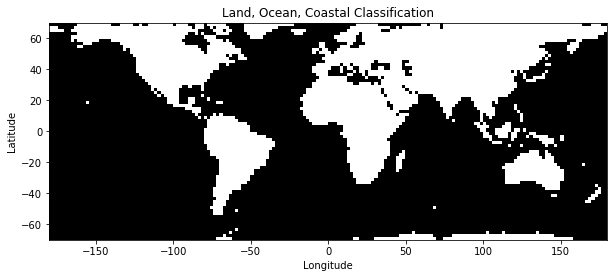

In [16]:
# Map categories to numerical values
mapping = {'land': 0, 'ocean': 1}#, 'coastal': 2}
numerical_data = classification_df.replace(mapping).values
numerical_df = pd.DataFrame(classification_df.replace(mapping).values)

# Create custom colormap
colors = ['white', 'black']#, 'red']
cmap = ListedColormap(colors)

# Plot the grid
plt.figure(figsize=(10, 5))
plt.imshow(numerical_data, cmap=cmap, origin='lower' , extent=[-180,180, -70, 70])
#plt.colorbar(ticks=[0, 1, 2], format=plt.FuncFormatter(lambda val, loc: ['land', 'ocean'],[int(val)]))

plt.title('Land, Ocean, Coastal Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [17]:
# 6. add a layer of coastal grid cells
updated_df = numerical_df.copy()

# iterate through the df to identify coastal cells
for i in tqdm(range(1, numerical_df.shape[0] - 1)):
    for j in range(1, numerical_df.shape[1] - 1):
        
        # only convert ocean cells to coastal
        if numerical_df.iat[i, j] == 1:  
            
            # get 3x3 matrix around current grid cell
            matrix = numerical_df.iloc[i-1:i+2, j-1:j+2].values
            land = any(0 in row for row in matrix)
            if land:
                updated_df.iat[i, j] = 2

# apply the updates to the original DataFrame
numerical_df = updated_df

100%|██████████| 68/68 [00:01<00:00, 43.70it/s]


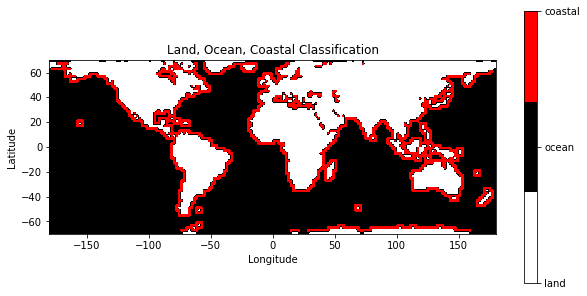

In [18]:
# assign colormap
colors = ['white', 'black', 'red']
cmap = ListedColormap(colors)

# plot
plt.figure(figsize=(10, 5))
plt.imshow(numerical_df.values, cmap=cmap, origin='lower' , extent=[-180,180, -70, 70])
plt.colorbar(ticks=[0, 1, 2], format=plt.FuncFormatter(lambda val, loc: ['land', 'ocean', 'coastal'][int(val)]))

plt.title('Land, Ocean, Coastal Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [19]:
# initialize counts
land_count = 0
ocean_count = 0
coastal_count = 0

# Iterate through the DataFrame
for i in range(1, numerical_df.shape[0] - 1):
    for j in range(1, numerical_df.shape[1] - 1):
        # extract the 3x3 matrix
        matrix = numerical_df.iloc[i-1:i+2, j-1:j+2].values
        land = any(0 in row for row in matrix)
        ocean = any(1 in row for row in matrix)
        if land and ocean:
            coastal_count += 1
        elif land:
            land_count += 1
        elif ocean:
            ocean_count += 1

# print counts
print('land:', land_count)
print('ocean:', ocean_count)
print('coastal:', coastal_count)

land: 3761
ocean: 7248
coastal: 1095


In [20]:
# 7. save classification as CSV:
numerical_df.to_csv('cell_geo_type.csv', index=False)